In [1]:
import sys
sys.path.insert(0, "./ffn-master/")
import ffn
import bt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
import json

C:\Anaconda3\envs\myquant2\lib\site-packages\ffn\core.py:27: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use('agg', warn=False)
C:\Anaconda3\envs\myquant2\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
#***********************This Section is to read from saved file and index*****************
concat_df=pd.read_csv('data/data_LGBM_Q.csv')
#concat_df=pd.read_csv('NSE_500_Output4.csv')
#concat_df=concat_df.drop(['Unnamed: 0', 'Return_2', 'Return_3', 'Return_4','Return_5'], axis=1)
concat_df['Date']= pd.to_datetime(concat_df['Date'])
concat_df=concat_df[concat_df['Date']>='2017-09-01']
concat_df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Company Name', 'Industry', 'Symbol',
       'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Share_Turnover', 'Return', 'Momentum', 'Mom_Sharpe', 'Mom_Gain_Loss',
       'Mom_Slope', 'StDev', 'Liquidity', 'Volatility', 'NSE500', 'CAPM_Beta',
       'CAPM_Alpha', 'Sector_Return', 'Sector_Momentum', 'EPS in Rs',
       'Net Profit', 'Sales', 'Sales_Growth', 'OPM_Growth', 'EPS_Growth',
       'Open_Shares', 'Promoters', 'FIIs', 'DIIs', 'Public', 'Promoters%',
       'DIIs%', 'FIIs%', 'Public%', 'EPS', 'E/P', 'PEG', 'S/P', 'Size_Factor',
       'Cum5_Return', 'LGBM_Prob_10_0.05', 'LGBM_Prob_10_0.075'],
      dtype='object')

In [3]:
concat_df.head()

,Unnamed: 0,Unnamed: 0.1,Company Name,Industry,Symbol,Date,Open,High,Low,Close,...,FIIs%,Public%,EPS,E/P,PEG,S/P,Size_Factor,Cum5_Return,LGBM_Prob_10_0.05,LGBM_Prob_10_0.075
0,0,0.0,3M India Ltd.,SERVICES,3MINDIA,2017-09-01,14780.000000,14780.0,14640.0,14689.799805,...,-0.003308,0.00369,52.99,0.003607,516.882470,0.043704,-9.719150,0.001145,0.014039,0.007177
1,1,1.0,3M India Ltd.,SERVICES,3MINDIA,2017-09-04,14780.000000,14780.0,14500.0,14634.799805,...,-0.003308,0.00369,52.99,0.003621,514.947213,0.043869,-9.715399,-0.003035,0.011419,0.007104
2,2,2.0,3M India Ltd.,SERVICES,3MINDIA,2017-09-05,14779.000000,14779.0,14480.0,14512.599609,...,-0.003308,0.00369,52.99,0.003651,510.647418,0.044238,-9.707014,0.009987,0.007972,0.008696
3,3,3.0,3M India Ltd.,SERVICES,3MINDIA,2017-09-06,14415.000000,14700.0,14415.0,14517.200195,...,-0.003308,0.00369,52.99,0.003650,510.809296,0.044224,-9.707331,0.007771,0.013352,0.009692
4,4,4.0,3M India Ltd.,SERVICES,3MINDIA,2017-09-07,14699.799805,14750.0,14480.5,14679.000000,...,-0.003308,0.00369,52.99,0.003610,516.502463,0.043736,-9.718415,-0.007207,0.024114,0.018877


In [4]:
concat_df['Date'].max()

Timestamp('2020-09-25 00:00:00')

In [5]:
concat_df = concat_df[concat_df.Industry != 'FINANCIAL SERVICES']
concat_df = concat_df[concat_df.Industry != 'CONSTRUCTION']
concat_df = concat_df[concat_df.Industry != 'MEDIA & ENTERTAINMENT']

In [6]:
screen_data=pd.read_csv('data/Peer_Ticker_nifty500_consoldiated_cleaned.csv')
screen_1=screen_data[screen_data['Debt / Eq'] < 0.4]
screen_2=screen_1[screen_1['Prom. Hold.  %'] > 20]
#screen_3=screen_2[screen_2['ROE  %'] > 15]
#screen_3=screen_3[screen_3['ROA 12M  %'] > 10]
screen_4=screen_2[screen_2['CMP  Rs.'] < 5000]
screen_4=screen_4['Ticker'].unique().tolist()
len(screen_4)

190

In [7]:
concat_df['Date'].max()

Timestamp('2020-09-25 00:00:00')

In [8]:
#concat_df=concat_df[concat_df['Date']>='3/3/2017']
#concat_df=concat_df[concat_df['Date']<='7/19/2020']
concat_df=concat_df[concat_df['Symbol'].isin(screen_4)]
#concat_df['Return_1']=concat_df.groupby("Symbol")['Return'].apply(lambda x: x.shift(-1))
#ml_df_range=concat_df['Date'].tolist()
#concat_df.count()

In [9]:
concat_df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Company Name', 'Industry', 'Symbol',
       'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Share_Turnover', 'Return', 'Momentum', 'Mom_Sharpe', 'Mom_Gain_Loss',
       'Mom_Slope', 'StDev', 'Liquidity', 'Volatility', 'NSE500', 'CAPM_Beta',
       'CAPM_Alpha', 'Sector_Return', 'Sector_Momentum', 'EPS in Rs',
       'Net Profit', 'Sales', 'Sales_Growth', 'OPM_Growth', 'EPS_Growth',
       'Open_Shares', 'Promoters', 'FIIs', 'DIIs', 'Public', 'Promoters%',
       'DIIs%', 'FIIs%', 'Public%', 'EPS', 'E/P', 'PEG', 'S/P', 'Size_Factor',
       'Cum5_Return', 'LGBM_Prob_10_0.05', 'LGBM_Prob_10_0.075'],
      dtype='object')

In [ ]:
concat_df['S/P'].min()

In [ ]:
concat_df['StDev']=concat_df['StDev']/100
#concat_df['S/P']=1/concat_df['PES']
#concat_df['Mom_Std']=concat_df['Momentum']*concat_df['StDev']
concat_df['Mom_Size']=concat_df['Momentum']+concat_df['Size_Factor']
#concat_df['Mom_RSI']=concat_df['Momentum']+concat_df['RSI']/100
concat_df['Mom_Size_Sec']=concat_df['Momentum']+concat_df['Size_Factor']+concat_df['Sector_Momentum']
concat_df['Mom_EP']=concat_df['Momentum']+concat_df['E/P']
concat_df['Mom_Size_Sales']=concat_df['Momentum']+concat_df['Size_Factor']+concat_df['Sales_Growth']
concat_df['Mom_Std_Sales']=concat_df['Momentum']+concat_df['StDev']+concat_df['Sales_Growth']
concat_df['Mom_Std_Sales_OPM']=concat_df['Momentum']+concat_df['StDev']+concat_df['Sales_Growth']+concat_df['OPM_Growth']
concat_df['Mom_Size_Sales_Sec']=concat_df['Momentum']+concat_df['Size_Factor']+concat_df['Sales_Growth']+concat_df['Sector_Momentum']
concat_df['Size_Sales']=concat_df['Size_Factor']+concat_df['Sales_Growth']
concat_df['Mom_Size_Sales_Std']=concat_df['Momentum']+concat_df['Size_Factor']+concat_df['Sales_Growth']+concat_df['StDev']
concat_df['Size_Sales_Std']=concat_df['Size_Factor']+concat_df['Sales_Growth']+concat_df['StDev']
concat_df['Sales_Std']=concat_df['Sales_Growth']+concat_df['StDev']
concat_df['Mom_Size_Std']=concat_df['Momentum']+concat_df['Size_Factor']+concat_df['StDev']
concat_df['Mom_Size_Std_Vol']=concat_df['Momentum']+concat_df['Size_Factor']+concat_df['StDev']+concat_df['Volatility']
concat_df['Size_Std']=concat_df['Size_Factor']+concat_df['StDev']
concat_df['Mom_Std']=concat_df['Momentum']+concat_df['StDev']
concat_df['Mom_Std_Sec']=concat_df['Momentum']+concat_df['StDev']+concat_df['Sector_Momentum']
concat_df['Mom_Size_OPM']=concat_df['Momentum']+concat_df['Size_Factor']+concat_df['OPM_Growth']
concat_df['Mom_Size_Sales_EP']=concat_df['Momentum']+concat_df['Size_Factor']+concat_df['Sales_Growth']+concat_df['E/P']
concat_df['Size_Sales_EP']=concat_df['Size_Factor']+concat_df['Sales_Growth']+concat_df['E/P']
concat_df['Mom_Size_EPS']=concat_df['Momentum']+concat_df['Size_Factor']+concat_df['EPS_Growth']
concat_df['Mom_Size_EP']=concat_df['Momentum']+concat_df['Size_Factor']+concat_df['E/P']*100
concat_df['Mom_Vol']=concat_df['Momentum']+concat_df['Volatility']
concat_df['Mom_Vol_StDev']=concat_df['Momentum']+concat_df['Volatility']+concat_df['StDev']
concat_df['Vol_StDev']=concat_df['Volatility']+concat_df['StDev']
concat_df.columns

In [11]:
def evaluate_Long_Portfolio(concat_df, factor_name, rebalance_period= 5,screen_stock=10):
    #date_rng = pd.date_range(start=concat_df['Date'].min(), end=concat_df['Date'].max(), freq=rebalance_period).tolist()
    date_rng=concat_df["Date"].map(lambda t: t.date()).unique().tolist()[0::rebalance_period]
    concat_df1=concat_df[concat_df['Date'].isin(date_rng)]
    concat_df2=concat_df1.groupby("Date").apply(lambda x: x.nlargest(screen_stock,factor_name)).droplevel(1)
    concat_df2=concat_df2.groupby(concat_df2.index).filter(lambda x:len(x) == screen_stock)
    screener_out=concat_df2
    concat_df2=concat_df2[['Symbol',factor_name]]
    concat_df2.reset_index()
    concat_df2['Scaled_Momentum']=concat_df2.groupby('Date')[factor_name].apply(lambda x: x/x.sum())
    concat_df2=concat_df2.reset_index()
    concat_df2=concat_df2.drop([factor_name],axis = 1)
    date_rng1=pd.date_range(start=concat_df2['Date'].min(), end=concat_df2['Date'].max(), freq='1D').tolist()
    date_rng2=concat_df2["Date"].map(lambda t: t.date()).unique().tolist()
    date_rng2=concat_df2["Date"].map(lambda t: t.date()).unique()
    z1=pd.DataFrame()
    for dt1 in date_rng1:
        t1=pd.DataFrame()
        old_date=dt1-pd.DateOffset(days=1)
        #print("Old Date is:", old_date)
        if(dt1 in date_rng2):
            #print("Inside If")
            t1=concat_df2[concat_df2['Date']==dt1]
            t1['Date']=dt1
        else:
            #print("Inside Else")
            t1=z1[z1['Date']==old_date]
            t1['Date']=dt1
        z1=z1.append(t1)
    concat_df5=concat_df[['Symbol', 'Date', 'Return']]
    concat_df5.head()
    concat_df6=z1.merge(concat_df5, how='right', on=['Date','Symbol'])
    concat_df7=pd.DataFrame()
    concat_df7['Mom_Return']=concat_df6.groupby("Date").apply(lambda x: np.sum(x['Scaled_Momentum']*x['Return']))
    concat_df7=concat_df7.loc[~(concat_df7==0).all(axis=1)]
    factor_plot='Plot_'+factor_name
    concat_df7[factor_plot]= (concat_df7['Mom_Return'] + 1).cumprod()
    concat_df7=concat_df7.drop(['Mom_Return'],axis=1)
    concat_df7.plot(y=factor_plot)
    return z1, concat_df7, screener_out  

In [12]:
out_add=pd.DataFrame()
def create_strategy_data(concat_df,factor_list,rebalance_period= 5,screen_stock=10):
    factor_return_frame=pd.DataFrame()
    for factor_name in factor_list:
        #print("Now processing for factor: ", factor_name)
        z1, factor_return,factor_screen=evaluate_Long_Portfolio(concat_df,factor_name, rebalance_period=rebalance_period,screen_stock=screen_stock)
        #print("***********Factor_Head",factor_return.columns,factor_return.index )
        #factor_return_frame[factor_name]=factor_return
        #print("Got data for factor: ", factor_name)
        factor_return=factor_return.sort_index()
        factor_return.rebase().head()
        #print(factor_return.columns)
        #feature_name="Plot_"+factor_name
        #factor_return_frame=factor_return_frame.append(factor_return)
        #factor_return_1=factor_return[feature_name].pct_change()
        factor_return_frame=pd.concat([factor_return_frame,factor_return], axis=1)
        riskfree_rate=0.0002765
        #stats.set_riskfree_rate(riskfree_rate)
        #stats.display()
        s_equal_weights_factor = bt.Strategy(factor_name, [bt.algos.RunQuarterly(),bt.algos.SelectAll(), bt.algos.WeighEqually(),bt.algos.Rebalance()])
        b_equal_weights_factor= bt.Backtest(s_equal_weights_factor, factor_return)
        result = bt.run(b_equal_weights_factor)
        #print("Done Calculating result for factor: ", factor_name)
        out_add[factor_name]=result.stats[factor_name]
    return out_add,factor_return_frame

In [ ]:
feature_list=['Sales_Growth', 'OPM_Growth', 'EPS_Growth', 'EPS', 'E/P', 'PES', 'Size_Factor','Momentum','StDev','Volatility','Mom_Vol','Mom_Vol_StDev' ,'Mom_Std', 'Mom_Size', 'Mom_EP',
       'Mom_Size_Sales','Mom_Std_Sales_OPM','Mom_Std_Sales', 'Mom_Size_Sales_Std', 'Mom_Size_Std','Mom_Size_Std_Vol','Mom_Size_OPM', 'Mom_Size_Sales_EP', 'Mom_Size_EPS', 'Mom_Size_EP','Size_Sales_Std','Sales_Std']
strategy_data,factor_return_frame=create_strategy_data(concat_df,feature_list,rebalance_period= 10,screen_stock=12)
#strategy_data.to_csv('strategy_data.csv')

In [ ]:
factor_return_frame.to_csv('data/Factor_Return_Q.csv')

First Portfolio of Sh Invested

In [ ]:
beginning = '2004-06-01'
data_nse50 = bt.get('^NSEI', start=beginning)
data_nse50=data_nse50[data_nse50.index>='6/5/2017']
data_nse50=data_nse50[data_nse50.index<'8/15/2020']
s_nse50 = bt.Strategy('Benchmark NIFTY50', 
                       [bt.algos.RunQuarterly(),
                       bt.algos.SelectAll(),
                       bt.algos.WeighEqually(),
                       bt.algos.Rebalance()])                    
b_nse50 = bt.Backtest(s_nse50, data_nse50)
result = bt.run(b_nse50)
result.plot()
strategy_data['Benchmark NIFTY50']=result.stats['Benchmark NIFTY50']

In [ ]:
beginning = '2004-06-01'
data_nsemid100 = bt.get('^CRSMID', start=beginning)
data_nsemid100=data_nsemid100[data_nsemid100.index>='6/5/2017']
data_nsemid100=data_nsemid100[data_nsemid100.index<'8/15/2020']
s_nsemid100 = bt.Strategy('Benchmark NiftyMid', 
                       [bt.algos.RunQuarterly(),
                       bt.algos.SelectAll(),
                       bt.algos.WeighEqually(),
                       bt.algos.Rebalance()])
                    
b_nsemid100 = bt.Backtest(s_nsemid100, data_nsemid100)
result = bt.run(b_nsemid100)
strategy_data['Benchmark NiftyMid']=result.stats['Benchmark NiftyMid']

In [ ]:
strategy_data.to_csv('data/strategy_data_Q_nifty500_6000.csv')

In [ ]:
strategy_data.columns

In [15]:
investment_amount=100000

In [13]:
def calculate_returns(factor_name,screener_out,concat_df, investment=50000,screen_stock=10):
    date_rng_screen=screener_out["Date"].map(lambda t: t.date()).unique().tolist()
    #print("Date Range is:", date_rng_screen)
    date_rng_screen_1 = date_rng_screen
    date_rng_screen_1.pop(0)
    date_rng_screen_2=list()
    for date in date_rng_screen_1:
        for i in range(screen_stock):
            date_rng_screen_2.append(date)
    screener_new=screener_out[:-screen_stock]
    #screener_new.to_csv("screener_new.csv")
    #print("Screen Date is:", screener_new['Date'].count(), len(date_rng_screen_2))
    screener_new['Sell_Date']=date_rng_screen_2
    screener_new=screener_new.rename(columns={"Date": "Buy_Date"})
    screener_new['Sell_Date']= pd.to_datetime(screener_new['Sell_Date'])
    concat_df1=concat_df[['Symbol','Date','Open','Close']]
    concat_df1['Adj Close']=(concat_df1['Open']+concat_df1['Close'])/2
    concat_df1=concat_df1.drop(['Open','Close'],axis=1)
    concat_df1['Adj Close']=concat_df1.groupby("Symbol")['Adj Close'].apply(lambda x: x.shift(-1))
    concat_df=concat_df1
    screener_new_1=screener_new.merge(concat_df[['Symbol','Date','Adj Close']],how='left',left_on=['Symbol','Buy_Date'], right_on=['Symbol','Date'])
    screener_new_1=screener_new_1.rename(columns={"Adj Close": "Buy_Price"})
    screener_new_1=screener_new_1.merge(concat_df[['Symbol','Date','Adj Close']],how='left',left_on=['Symbol','Sell_Date'], right_on=['Symbol','Date'])
    screener_new_1=screener_new_1.rename(columns={"Adj Close": "Sell_Price"})
    screener_new_1=screener_new_1.drop(['Date_x','Date_y'],axis = 1)
    screener_new_2 = screener_new_1.groupby('Buy_Date').apply(lambda x: investment* x[factor_name] /x['Buy_Price']).droplevel(1).reset_index()
    screener_new_2=screener_new_2.rename(columns={ 0: "Shares"})
    screener_new_1['Shares']=screener_new_2['Shares'].tolist()
    screener_new_1['Profit']=(screener_new_1['Sell_Price']-screener_new_1['Buy_Price'])*screener_new_1['Shares']
    screener_new_1=screener_new_1.rename(columns={ factor_name: "Factor_Screen_Value"})
    screener_new_1['Factor_Name']=factor_name
    screener_profit=pd.DataFrame()
    screener_profit['Percentage']=(screener_new_1.groupby('Sell_Date')['Profit'].sum())/investment
    screener_profit['INR']=screener_profit['Percentage']*investment
    screener_profit['Factor_Name']=factor_name
    screener_detailed=screener_new_1
    return screener_profit,screener_detailed

In [30]:
screener_detailed_df=pd.DataFrame()
screener_profit_df=pd.DataFrame()
#rebalance_period_list=[5,10,20]
#screen_stock_list=[10,12,15]
rebalance_period_list=[10]
screen_stock_list=[10]
for rebalance_period in rebalance_period_list:
    for screen_stock in screen_stock_list:
        print("Now Processing for rebalance period:",rebalance_period," &: screen_stock: ",screen_stock )
        #factor_list=['Mom_Size_Sales','10_Mom_Size_Sales','Mom_Size_10_Sales','Mom_Size_Sales_10']
        factor_list=['Sales_Growth', 'OPM_Growth', 'EPS_Growth', 'EPS', 'E/P', 'PES', 'LGBM_Prob_10_0.0', 'LGBM_Prob_10_0.02',
       'LGBM_Prob_10_0.05','Size_Factor','Momentum','StDev','Volatility','Mom_Vol','Mom_Vol_StDev' ,'Mom_Std', 'Mom_Size', 'Mom_EP',
       'Mom_Size_Sales','Mom_Std_Sales_OPM','Mom_Std_Sales', 'Mom_Size_Sales_Std', 'Mom_Size_Std','Mom_Size_Std_Vol','Mom_Size_OPM', 'Mom_Size_Sales_EP', 'Mom_Size_EPS', 'Mom_Size_EP','Size_Sales_Std','Sales_Std']
        for factor_name in factor_list:
            print("Now processing for factor: ", factor_name)
            z1, concat_df7, screener_out = evaluate_Long_Portfolio(concat_df,factor_name , rebalance_period= rebalance_period,screen_stock=screen_stock)
            screener_out=screener_out[['Symbol',factor_name]]
            s1=screener_out
            screener_out=screener_out.groupby(['Date']).filter(lambda x:len(x) == screen_stock)
            screener_out.reset_index()
            screener_out[factor_name]=screener_out.groupby('Date')[factor_name].apply(lambda x:x/sum(x))
            screener_out=screener_out.reset_index()
            print('Screener Date Count:', len(screener_out["Date"].map(lambda t: t.date()).unique().tolist()))
            #screener_out.to_csv('screener_momentum.csv')
            screener_profit,screener_detailed=calculate_returns(factor_name,screener_out,concat_df, investment=investment_amount,screen_stock=screen_stock)
            screener_profit['rebalance_period']=rebalance_period
            screener_profit['screen_stock']=screen_stock
            screener_detailed['rebalance_period']=rebalance_period
            screener_detailed['screen_stock']=screen_stock
            screener_detailed_df=screener_detailed_df.append(screener_detailed)
            screener_profit_df=screener_profit_df.append(screener_profit)
            print("Done processing for factor: ", factor_name)
screener_detailed_df.to_csv('data/GBM_screener_detailed_df_base_all_features_Avg_Q_nifty500_3500.csv')
screener_profit_df.to_csv('data/GBM_screener_profit_df_base_all_features_Avg_Q_nifty500_3500.csv')

Now Processing for rebalance period: 10  &: screen_stock:  10
Now processing for factor:  Sales_Growth


KeyboardInterrupt: 

In [19]:
screener_detailed_df1=screener_detailed_df[screener_detailed_df['Sell_Date']>='3/3/2015']
Factor_Efficieny=pd.DataFrame()
Factor_Efficieny['Profit']=screener_detailed_df1.groupby('Factor_Name')['Profit'].sum()
Factor_Efficieny['Profit_Stdev']=screener_detailed_df1.groupby('Factor_Name')['Profit'].std()
Factor_Efficieny['Correct_Bets']=screener_detailed_df1.groupby('Factor_Name').apply(lambda x:x[x['Profit']>0]['Profit'].count()/x['Profit'].count())

In [20]:
screener_detailed_df['Buy_Date'].unique()

array(['2017-09-01T00:00:00.000000000', '2017-09-15T00:00:00.000000000',
       '2017-09-29T00:00:00.000000000', '2017-10-16T00:00:00.000000000',
       '2017-10-31T00:00:00.000000000', '2017-11-14T00:00:00.000000000',
       '2017-11-28T00:00:00.000000000', '2017-12-12T00:00:00.000000000',
       '2017-12-27T00:00:00.000000000', '2018-01-10T00:00:00.000000000',
       '2018-01-24T00:00:00.000000000', '2018-02-08T00:00:00.000000000',
       '2018-02-23T00:00:00.000000000', '2018-03-12T00:00:00.000000000',
       '2018-03-26T00:00:00.000000000', '2018-04-11T00:00:00.000000000',
       '2018-04-25T00:00:00.000000000', '2018-05-10T00:00:00.000000000',
       '2018-05-24T00:00:00.000000000', '2018-06-07T00:00:00.000000000',
       '2018-06-21T00:00:00.000000000', '2018-07-05T00:00:00.000000000',
       '2018-07-19T00:00:00.000000000', '2018-08-02T00:00:00.000000000',
       '2018-08-17T00:00:00.000000000', '2018-09-03T00:00:00.000000000',
       '2018-09-18T00:00:00.000000000', '2018-10-04

In [21]:
f1=screener_detailed_df1.groupby(['Buy_Date','Factor_Name'])['Profit'].sum().reset_index()
f1['Rank']=f1.groupby('Buy_Date')['Profit'].rank()
f1['Rank'] = pd.qcut(f1['Rank'], 10, labels=False)
f1.to_csv('data/GBM_Rank_Factor.csv')

In [22]:
Factor_Efficieny.sort_values(by='Profit', ascending=False)

,Profit,Profit_Stdev,Correct_Bets
Factor_Name,,,
LGBM_Prob_10_0.05,582208.913892,1147.792808,0.841096
LGBM_Prob_10_0.02,501321.783695,1035.620412,0.858904
LGBM_Prob_10_0.0,413915.086933,943.496897,0.850685
Mom_Size_Sales_Std,169936.967641,1548.310345,0.553425
Mom_Size_Sales_EP,161386.382529,1208.241385,0.554795
Mom_Std_Sales,161038.811671,1589.483002,0.549315
Mom_Size_Sales,160226.387436,1196.700146,0.556164
Size_Sales_Std,131518.057696,1506.488982,0.531507
Sales_Std,129541.448082,1552.324987,0.529492


In [ ]:
Factor_Efficieny=Factor_Efficieny.reset_index()
Factor_Efficieny.to_csv('data/GBM_Factor_Efficieny_Date_base_all_features.csv')
Factor_Efficieny.head(20)

In [ ]:
Factor_Efficieny.sort_values(by='Profit', ascending=False)

In [ ]:
Factor_Efficieny_Date=pd.DataFrame()
Factor_Efficieny_Date['Profit']=screener_detailed_df1.groupby(['Sell_Date','Factor_Name'])['Profit'].sum()
Factor_Efficieny_Date['Profit_Stdev']=screener_detailed_df1.groupby(['Sell_Date','Factor_Name'])['Profit'].std()
Factor_Efficieny_Date['Profit_Bets']=screener_detailed_df1.groupby(['Sell_Date','Factor_Name']).apply(lambda x:x[x['Profit']>0]['Profit'].count()/x['Profit'].count())
Factor_Efficieny['Correct_Bet_50']=Factor_Efficieny_Date.groupby('Factor_Name').apply(lambda x:x[x['Profit_Bets']>0.5]['Profit_Bets'].count()/x['Profit_Bets'].count())
Factor_Efficieny.head(20)

In [ ]:
Factor_Efficieny.to_csv('data/GBM_Factor_Efficieny.csv')

In [ ]:
screener_detailed_df1=screener_detailed_df

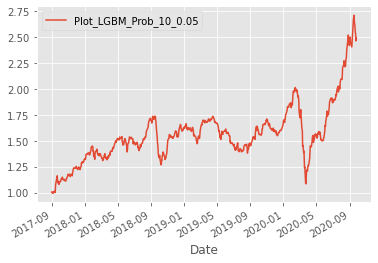

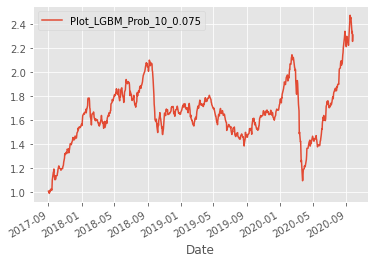

In [16]:
investment_amount=150000
feature_name_list=[ 'LGBM_Prob_10_0.05',
       'LGBM_Prob_10_0.075']
for feature_name in feature_name_list:
    z1, concat_df7, screener_out = evaluate_Long_Portfolio(concat_df, feature_name, rebalance_period= 1,screen_stock=8)
    screener_out=screener_out[['Symbol',feature_name]]
    screener_out.reset_index()
    screener_out[feature_name]=screener_out.groupby('Date')[feature_name].apply(lambda x:x/sum(x))
    #screener_out.to_csv('Momentum_features.csv')
    screener=screener_out.merge(concat_df[['Symbol','Date','Adj Close']], how='left', on=(['Date','Symbol']))
    screener['Invest_Amount']=screener[feature_name]*investment_amount
    screener['Shares']=(screener['Invest_Amount']/screener['Adj Close']).round()
    filename="data/LGBM_Q_Screener_"+feature_name+".csv"
    screener.sort_values(by=['Date'],ascending=False).to_csv(filename)

In [ ]:
def calc_turnover(concat_df):
    d1=pd.DataFrame()
    concat_df=concat_df.sort_values(by='Date')
    d1['Date']=pd.to_datetime(concat_df['Date'].map(lambda t: t.date()).unique().tolist())
    d1['Month1']=d1['Date'].map(lambda t: t.date().month).tolist()
    d1['Month1']=d1['Month1'].astype(str)
    d1['Year']=d1['Date'].map(lambda t: t.date().year).tolist()
    d1['Year']=d1['Year'].astype(str)
    d1['Month1']=d1['Month1']+"_"+d1['Year']
    z2=sorted(d1.groupby("Month1").apply(lambda x:x['Date'].max()).tolist())
    z3=pd.DataFrame()
    z3['Date']=pd.Series(z2)
    z3=z3.reset_index()
    z3['month_index']=z3['index']+1
    concat_df3=concat_df.groupby("Date").apply(lambda x: x.nlargest(15,'Momentum')).droplevel(1)
    concat_df3=concat_df3.reset_index(drop=True)
    concat_df3['Scaled_Momentum']=concat_df3.groupby('Date')['Momentum'].apply(lambda x: x/x.sum())
    concat_old=concat_new=pd.merge(z3,concat_df3, how='left', on=['Date'])
    concat_old=concat_old[['month_index','Date','Symbol','Scaled_Momentum']]
    concat_old['month_index']="count_"+ concat_old['month_index'].astype(str)
    concat_new=concat_new[['month_index','Date','Symbol','Scaled_Momentum']]
    concat_new['month_index']="count_"+ (concat_new['month_index']+1).astype(str)
    merged_df_turnover=pd.merge(concat_old,concat_new,how='outer',on=['month_index','Symbol'])
    merged_df_turnover['Date']=merged_df_turnover.groupby('month_index')['Date_x'].fillna(method='ffill')
    merged_df_turnover['Scaled_Momentum_x']=merged_df_turnover.groupby('month_index')['Scaled_Momentum_x'].fillna(0)
    merged_df_turnover['Scaled_Momentum_y']=merged_df_turnover.groupby('month_index')['Scaled_Momentum_y'].fillna(0)
    merged_df_turnover.columns
    merged_df_turnover=merged_df_turnover[['Date','Symbol','Scaled_Momentum_x','Scaled_Momentum_y']]
    z4=pd.DataFrame()
    z4['Turnover']=merged_df_turnover.groupby('Date').apply(lambda x:np.sum(abs(x['Scaled_Momentum_x']-x['Scaled_Momentum_y'])))
    z4['Year']=pd.DatetimeIndex(z4.index).year
    z5= z4.groupby('Year').sum()
    return z5

In [ ]:
calc_turnover(concat_df[['Mom_Avg']])

In [ ]:
b_screener_detailed_df.groupby('Buy_Date').count().to_csv('bench.csv')

In [ ]:
b_screener_detailed_df1.to_csv('4.csv')

In [ ]:
b_screener_detailed_df.to_csv('2.csv')

In [ ]:
b_screener_detailed_df.head()

In [ ]:
b_screener_detailed_df['Factor_Name'].unique()

In [ ]:
import itertools
stuff = [1, 2, 3]
for L in range(0, len(stuff)+1):
    for subset in itertools.combinations(stuff, L):
        print(subset,type(subset))

In [ ]:
z=(1,2,3)

In [ ]:
len(z)